<a href="https://colab.research.google.com/github/victor-MMN/RNN-recurrentes/blob/master/Ev3_SFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Minjares Neriz Victor Manuel***

---



---




### **1. Transferir directamente de Kaggle a Google Colab**

Si ya hiciste este paso antes solo manta el drive y saltate al 2.


In [ ]:
#Primeramente debemos subir el archivo kaggle.json a google colab
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victorminjares","key":"112ab805aae61c17b52c691948269c28"}'}

In [ ]:
# comandos para permitir que google descargue datos de kaggle. 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
# debemos verificar que nuestro disco gdrive este montado 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Descargar la muestra de datos deseada 
!kaggle datasets download -d kandij/electric-production -p /content/drive/MyDrive/computacional

  0% 0.00/2.63k [00:00<?, ?B/s]
100% 2.63k/2.63k [00:00<00:00, 394kB/s]


In [ ]:
#Ir al directorio donde se descargo y descomprimir el archivo .zip debe tener la misma estructura que en la pagina de kaggle
import os 
os.chdir("/content/drive/MyDrive/computacional")
!unzip -q electric-production.zip

## **2. Dataset**

In [ ]:
# Librerias:


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

# Creamos una semilla para reproducir los resultados
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [ ]:
# Direccion con el archivo de datos .csv, con parse_dates hacemos que al graficar solo salga
# el año y no se vea todo amontonado en el eje.
dataset = pd.read_csv("/content/drive/MyDrive/computacional/Electric_Production.csv", parse_dates=['DATE'])

In [ ]:
dataset.head(400)

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [ ]:
dataset.shape

(397, 2)

Text(0, 0.5, 'Consumo porcentual de electricidad')

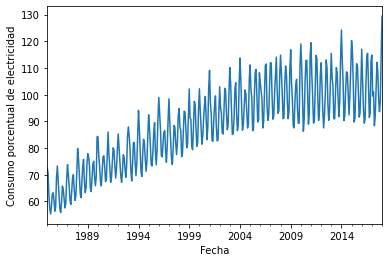

In [ ]:
# Graficamos los datos

ax = dataset.plot(x='DATE', y='Value', legend = False);
ax.set_xlabel("Fecha")
ax.set_ylabel("Consumo porcentual de electricidad")

## **3. Modelo**

In [ ]:
# Difersos argumentos a utilizar

n_timestamp = 10  # Numero de dias en un bloque de tiempo.
train_days = 300  # Numero de dias a usar para entrenar.
testing_days = 97 # Numero de dias que se usaran para predecir.
n_epochs = 100
act_fun = 'sigmoid'
batchS = 32
opti = 'adam'

# Seleccionar tipo de modelo
# 1: Single cell
# 2: Stacked
# 3: Bidirectional

model_type = 1

In [ ]:
# Configurar numero de datos de entrenamiento y testeo

train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values


In [ ]:
# Normalizamos los datos.

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [ ]:
# Separamos los datos en  n marcas de tiempo

def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)


(290, 10, 1)
(87, 10, 1)


In [ ]:
# Programamos los modelos

if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation=act_fun,input_shape = (X_train.shape[1], 1)))
    # model.add(Dropout(rate=0.2))
    model.add(Dense(units = 1))
    print("Single cell LSTM")
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation=act_fun, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation=act_fun))
    # model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    print("Stacked LSTM")
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation=act_fun), input_shape=(X_train.shape[1], 1)))
    # model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    print("Bidirectional LSTM")


Single cell LSTM


## **4. Entrenamiento**

In [ ]:
model.compile(optimizer = opti, loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batchS,validation_split=0.1)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/100
9/9 [==============================] - 2s 44ms/step - loss: 0.0676 - val_loss: 0.0486
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0402 - val_loss: 0.1191
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0439 - val_loss: 0.0666
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0388 - val_loss: 0.0912
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0354 - val_loss: 0.0671
Epoch 6/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0346 - val_loss: 0.0733
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0346 - val_loss: 0.0729
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0303 - val_loss: 0.0667
Epoch 9/100
9/9 [==============================] - 0s 13ms/step - loss: 0.0291 - val_loss: 0.0646
Epoch 10/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0333 - val_loss: 0.0648
Epoch 11/100
9/9 [=

## **5. Predicion**

In [ ]:
# Predicion de datos

y_predicted = model.predict(X_test)


#  Desnormalizamos los datos.

y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

# **Resultados**

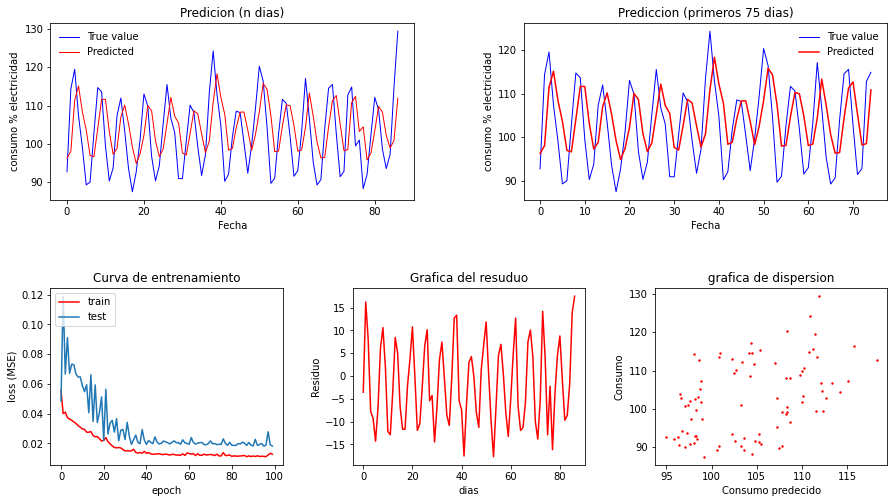

mse=82.22
r2=0.13


In [ ]:
plt.figure(figsize=(15,13))

#plt.subplot(3, 1, 1)
#plt.plot(dataset['Value'], color = 'blue', linewidth=1, label = 'True value')
#plt.ylabel("consumption % electricity")
#plt.xlabel("Date")
#plt.title("All data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("consumo % electricidad")
plt.xlabel("Fecha")
plt.title("Predicion (n dias)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:75], color = 'blue', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:75], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("consumo % electricidad")
plt.xlabel("Fecha")
plt.title("Prediccion (primeros 75 dias)")

plt.subplot(3, 3, 7)
plt.plot(history.history['loss'], color = 'red')
plt.plot(history.history['val_loss'])
plt.title('modelo loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Curva de entrenamiento")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='red')
plt.ylabel("Residuo")
plt.xlabel("dias")
plt.title("Grafica del resuduo")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='red')
plt.ylabel("Consumo")
plt.xlabel("Consumo predecido")
plt.title(" grafica de dispersion ")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))